# 0. Theory about PSO

The core idea ia a **Wisdom of the crowd**. Example:  

Imagine you've lost your keys in a large, dark field. You have a group of friends (a "swarm") to help you search. No one knows where the keys are, but every time a friend takes a step, they know if they are getting "warmer" or "colder" from the keys.    

**How would this group search effectively?**  
1. Individual memory: Each person would remember the "warmest" spot the personally have found so far.  
2. Shared information: The entire group would communicae, and everyone would know about the single "Warmest" spot found by any member of the group so far.  

A person's next step would likely be a combination of three things:  

* Continuing in the general direction there were already heading  
* Moving back toward thei own personal best spot  
* Moving toward the group's overall best spot.   


# 0.1 Adaptation of algorithm to our task

* Particle: A single agent, searcher in our case is a potential solution so a specific coordinate pair (x,y)  
* Swarm: The list of coordinates  
* Position:  2D vector (x,y)  
* Velocity: The direction and magnitude of a particle's movement. How posiiton is updated in each step. 2D vector  
* Fitness solution/Cost function: A lower value of f(x,y) means a better (Fitter) postion.  
* Personal best: The best position that a specific particle has visited so far.   
* Global best: The best position found by any particle in the entire swarm. This single value shared among all particles. 



# 1.0 Implementing algorithm

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import ffmpeg

LOWER_BOUND = -4.5
UPPER_BOUND = 4.5
PROBLEM_DIMENSIONS = 2


class Particle():
    """Single particle in the swarm optimization algorithm"""
    def __init__(self):
        """Initializes a particle with a random state"""
        self.current_position = np.random.uniform(LOWER_BOUND, UPPER_BOUND, PROBLEM_DIMENSIONS) # third argument is a size
        self.velocity = np.random.uniform(-0.1, 0.1, PROBLEM_DIMENSIONS)
        self.personal_best_position = self.current_position.copy() 
        self.personal_best_value = float('inf')



In [2]:
def fitness_function(position: np.ndarray) -> float:
    """
    Calculate the fitness value for a given position (f(x,y)).
    
    Args:
        position (np.ndarray): The particle's position, coordinates (x,y)
    """
    x, y = position[0], position[1]
    term1 = (1.5 - x - x*y)**2
    term2 = (2.25 - x + x*y**2)**2
    term3 = (2.625 - x + x*y**3)**2
    return term1 + term2 + term3

In [3]:
class PSOOptimizer():
    """The Particle Swarm Optimization algorithm"""
    def __init__(self, fitness_func, n_particles: int = 30,
                w: float = 0.7, c1: float = 1.5, c2: float = 1.5):
        """
        Initializes the PSO Optimizer.

        Args:
            function (callable): The function to minimize. It must take a numpy array of positions
            n_particles (int): The number oof particles in the swarm.
            w (float): The inertia weight. Controls the particle's tendency to keep moving in its current direction. A high value
                like 0.9 encourages global exploration. Smaller like 0.4 encourages local exploration.
            c1 (float): The cognitive coefficient. The value controls the 'pull' of the particle towards its own personal best position
            c2 (float): The social coefficient. The value controls the 'pull' of the particle towards swarm's best position
        """
        self.fitness_func = fitness_func
        self.n_particles = n_particles
        self.w = w
        self.c1 = c1
        self.c2 = c2

        # Initialize global best state
        self.gbest_position = None
        self.gbest_value = float('inf')
        
        # Create particles
        self.particles = [Particle() for _ in range(self.n_particles)]

        # Initialize swarm's pbest and gbest
        self._initialize_swarm()

    
    def _initialize_swarm(self):
        """Initialize the personal and global best values for the swarm"""
        # Loop over the already existing particle list
        for particle in self.particles:
            particle.personal_best_value = self.fitness_func(particle.current_position) # The particle's current fitness is its first and only
            # Particle's personal best position is copied of current position during initialization 
            if particle.personal_best_value < self.gbest_value:
                self.gbest_value = particle.personal_best_value
                self.gbest_position = particle.personal_best_position.copy()

    
    def _optimize_single_run(self) -> tuple[np.ndarray, float]:
        """
        Internal Function of optimizing the Particle Swarm Algorithm
        
        Returns:
            A tuple containing (best_position, best_value)
        """
        for particle in self.particles: # For every particle
            
            # Update velocity 
            r1 = np.random.rand(PROBLEM_DIMENSIONS) # r1 = [dx, dy] becose below there will be broadcasting 
            r2 = np.random.rand(PROBLEM_DIMENSIONS)
            cognitive_term = (self.c1 * r1 * (particle.personal_best_position - particle.current_position))
            social_term = self.c2 * r2 * (self.gbest_position - particle.current_position)
            new_velocity =  (self.w * particle.velocity) + cognitive_term + social_term
            
            # Update new position
            new_position = particle.current_position + new_velocity

            # Handling boundaries
            clipped_position = np.clip(new_position, LOWER_BOUND, UPPER_BOUND)

            # Asign new posiion to paticle
            particle.current_position = clipped_position

            # Calculate fitness
            current_value = fitness_function(particle.current_position)

            # Compare pbest value and pb_position
            if current_value < particle.personal_best_value:
                particle.personal_best_value = current_value
                particle.personal_best_position = particle.current_position

            # Compare pbest value with swarm's best value
            if particle.personal_best_value < self.gbest_value:
                self.gbest_value = particle.personal_best_value
                self.gbest_position = particle.personal_best_position.copy()


    def optimize(self, max_iterations: int) -> tuple[np.ndarray, float, list]:
        """Runs the PSO algorithm and records the covergance history"""
        history = [] # A list to store global best value at each iteration
        for _ in range(max_iterations):
            self._optimize_single_run()
            history.append(self.gbest_value)
        return self.gbest_position, self.gbest_value, history
    

    def optimize_generator(self, max_iterations: int):
        """A generator that yields the state of the swarm at each iteration"""
        for _ in range(max_iterations):
            self._optimize_single_run()
            yield self.particles, self.gbest_position

In [4]:
def run_and_plot(param_sets: dict, iterations: int):
    """Runs PSO Algorithm using different parameters and plot results"""
    # Dictioniaries to hold results for different plot groups
    inertia_results = {}
    swarm_size_results = {}

    # Run PSO with different parameters
    for name, params in param_sets.items():
        print(f"Runnning: {name}...")
        particle_swarm_optimizer = PSOOptimizer(
            fitness_func=fitness_function,
            n_particles=params["n_particles"],
            w=params["w"],
            c1=params["c1"],
            c2=params["c2"]
            )
        
        # Store history for plots
        _, _, history = particle_swarm_optimizer.optimize(max_iterations=iterations)

        # Group results for plotting
        if "Inertia" in name:
            inertia_results[name] = history
        elif "swarm" in name:
            swarm_size_results[name] = history
        
    _plot("Impact oof Inertia weight (W)", inertia_results, iterations)
    _plot("Impact of swarm size (n_particles)", swarm_size_results, iterations)


def _plot(title: str, results: dict, iterations: int):
    """
    Helper function to create a plot.

    Args:
        title (str): Title of the plot
        results (dict): A dictioniary with a history of best global values
        iterations (int): How many iterations were passed for PSO.
    """
    plt.figure(figsize=(12,7))

    for name, history in results.items():
        plt.plot(range(iterations), history, label=name)
    
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Best Fitness Value (log scale)")
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()


def animate_swarm_movement(params: dict, iterations: int):
    """Generates an iteractive animation of the swarm"""
    print(f"Generating animation for: {params["name"]}...")

    particle_swarm_optimizer = PSOOptimizer(fitness_func=fitness_function, **params['values'])

    fig, ax = plt.subplots(figsize=(8,6))
    x_range = np.linspace(LOWER_BOUND, UPPER_BOUND, 100)
    y_range = np.linspace(LOWER_BOUND, UPPER_BOUND, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = fitness_function(np.array([X, Y]))

    ax.contourf(X, Y, Z, levels=50, cmap=plt.cm.viridis)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"PSO movement - {params['name']}")

    particle_scatter = ax.scatter([], [], c="yellow", s=5, alpha=0.7) # We can keep empty lists
    gbest_marker = ax.scatter([], [], c="red", marker="X", s=100, label="Gloobal best")
    ax.legend()

    def update(frame_data):
        particles, gbest_pos = frame_data
        positions = np.array([p.current_position for p in particles]) # Positions of all particles 
        particle_scatter.set_offsets(positions)
        gbest_marker.set_offsets(gbest_pos)
        return particle_scatter, gbest_marker
    

    animation = FuncAnimation(
        fig, 
        update, # Why update has no arguments? Because FunAnimation is passes arguments in the frames. 
        frames=particle_swarm_optimizer.optimize_generator(max_iterations=iterations), # Optimize_generatoor returns particles and gbest
        blit=True, # Blitting, istead of redrawing the entire plot for every time, it only redraws
        # the small rectangular regions that have changed
        interval=200, 
        repeat=True
        )
    animation.save(filename="pso_animated.gif", writer='pillow', fps=5)
    plt.close(fig) # Prevents a static image from also apperating

    print(f"Final best position is: {particle_swarm_optimizer.gbest_position}")
    print(f"Final best value is: {particle_swarm_optimizer.gbest_value}")
    


Runnning: Small Inertia (w=0.4), individual particle...
Runnning: Balanced Inertia (w=0.7), individual particle...
Runnning: High Inertia (w=0.9), individual particle...
Runnning: Small swarm (n=10), individual particle...
Runnning: Medium swarm (n=30), individual particle...
Runnning: Big swarm (n=50), individual particle...
Runnning: Small Inertia (w=0.4), social particle...
Runnning: Balanced Inertia (w=0.7), social particle...
Runnning: High Inertia (w=0.9), social particle...
Runnning: Small swarm (n=10), social particle...
Runnning: Medium swarm (n=30), social particle...
Runnning: Big swarm (n=50), social particle...
Runnning: Medium swarm (n=30), balanced inertia (w=0.7), balanced particle...


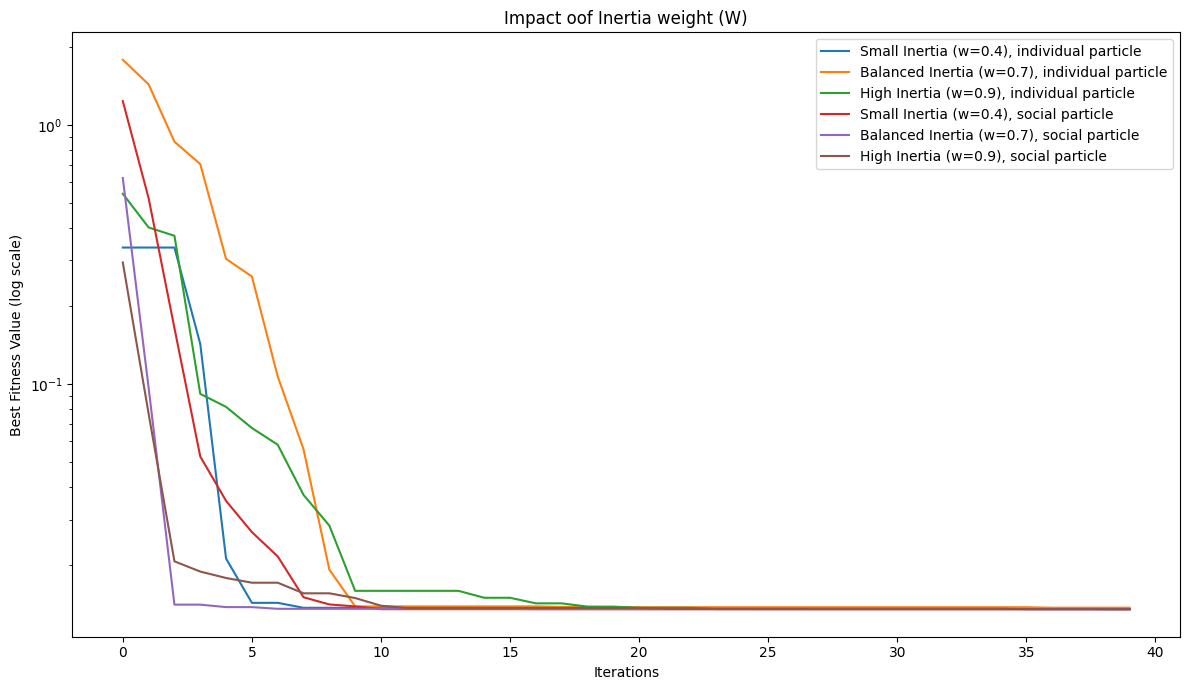

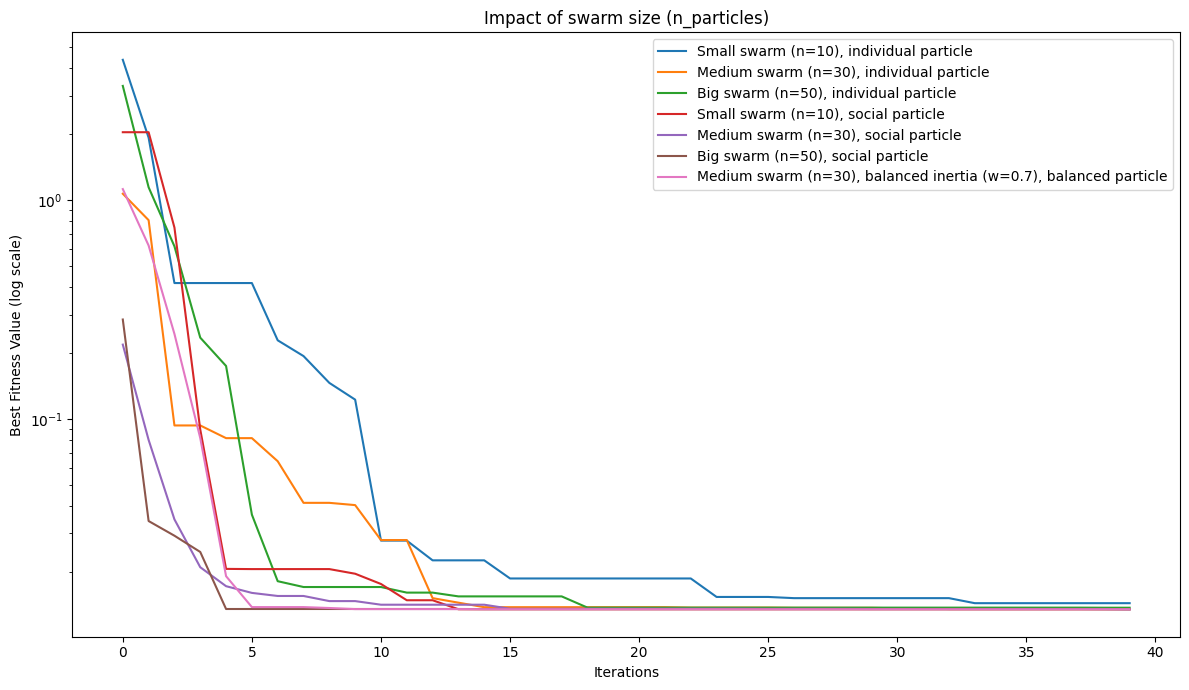

Generating animation for: Balanced Particle (w=0.7, n=30, c1=1.5, c2=1.5)...


C:\Users\pawel\AppData\Local\Temp\ipykernel_41684\1303245190.py:82: UserWarning: frames=<generator object PSOOptimizer.optimize_generator at 0x000001BC2AF0E5A0> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = FuncAnimation(


Final best position is: [ 2.51908668 -0.37442376]
Final best value is: 0.013518617378974309


<function __main__.animate_swarm_movement(params: dict, iterations: int)>

In [5]:
param_sets = {
    # Inertia
    "Small Inertia (w=0.4), individual particle": {"w": 0.4, "c1": 2.5, "c2": 0.5, "n_particles":30},
    "Balanced Inertia (w=0.7), individual particle":{"w": 0.7, "c1": 2.5, "c2": 0.5, "n_particles":30},
    "High Inertia (w=0.9), individual particle":{"w": 0.9, "c1": 2.5, "c2": 0.5, "n_particles":30},
    
    # Swarm size
    "Small swarm (n=10), individual particle":{"w": 0.7, "c1": 2.5, "c2": 0.5, "n_particles":10},
    "Medium swarm (n=30), individual particle":{"w": 0.7, "c1": 2.5, "c2": 0.5, "n_particles":30},
    "Big swarm (n=50), individual particle":{"w": 0.7, "c1": 2.5, "c2": 0.5, "n_particles":50},

    # Inertia
    "Small Inertia (w=0.4), social particle":{"w": 0.4, "c1": 0.5, "c2": 2.5, "n_particles":30},
    "Balanced Inertia (w=0.7), social particle":{"w": 0.7, "c1": 0.5, "c2": 2.5, "n_particles":30},
    "High Inertia (w=0.9), social particle":{"w": 0.9, "c1": 0.5, "c2": 2.5, "n_particles":30},
    
    # Swarm size
    "Small swarm (n=10), social particle":{"w": 0.7, "c1": 0.5, "c2": 2.5, "n_particles":10},
    "Medium swarm (n=30), social particle":{"w": 0.7, "c1": 0.5, "c2": 2.5, "n_particles":30},
    "Big swarm (n=50), social particle":{"w": 0.7, "c1": 0.5, "c2": 2.5, "n_particles":50},

    # Balanced particle
    "Medium swarm (n=30), balanced inertia (w=0.7), balanced particle":{"w": 0.7, "c1": 1.5, "c2": 1.5, "n_particles":30}
}   

run_and_plot(param_sets=param_sets, iterations=40)
plt.show()

balanced_params = {
    "name": "Balanced Particle (w=0.7, n=30, c1=1.5, c2=1.5)",
    "values": {"w": 0.7, "c1": 1.5, "c2": 1.5, "n_particles": 30}

}
animate_swarm_movement(balanced_params, iterations=40)
animate_swarm_movement

![GIF PSO movement](pso_animated.gif)

![Wolphram diagram](Wolphram.PNG)

![Minimum from wolphram alpha](Minimum.PNG)

# 2.0 Conclusion

1. The worst results have small swarm with individaul particles  
2. Balanced inertia has given better results   
3. Difference between medium and large size of swarm is marginally  
4. The best results were given for case with medium swarm, balanced inertia, c1 and c2
5. If we compare individual particles with social particles, the 2nd ones have better results.  